# Visualizing Pi

Some time ago I saw someones (sadly I cannot find this persons blog anymore) visualization of Pi using R's ggplot2. 
The visualization itself showed a path of line segments colored from blue to red. The idea was to have every number between 0...9 make a vector with endpoints evenly distributed on a circle. So we start at the origin, add the vector for the number 3, then add the vector for number 1, then 4, etc.
As I found the idea visuall and conceptually interesting I decided to implement this myself in R. Using ggplot2 this is suprisingly easy and needs very little code. I have now moved to Python and this is my try on this particular visualization using Python.

In [1]:
# first of all the imports

import math
import numpy as np
import pandas as pd

import requests
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.path as mpath

Now we need to get the number Pi. This could either be done by calculating the number, which is processing and memory heavy if we want to get many decimals, or we import it from a website.
So in this case lets just use BeautifulsSoup and request to get the number in the memory-friendly string format.

In [2]:
def get_pi_as_string():
    ''' 
    Take the digits of Pi from a website as a string, clean it and return it.
    If you want a higher or lower number of Pi's digits, you can change the number of zeroes in the websites url.
    They have up to one million digits.
    '''

    r = requests.get("http://www.eveandersson.com/pi/digits/10000")
    doc = BeautifulSoup(r.text, "html.parser").select_one("pre").text.strip()
    pi_decimal = doc.replace(" ", "").replace(".", "").replace("\n", "")
    return pi_decimal


Now we need to prepare the data and give every digit of Pi a coordinate. 
This is done by initializing a pandas dataframe with a numpy zeros matrix followed by running through the indices of said dataframe and adding the vector of every digit to the last digits endpoints. 
Because I want to start at the origin, I added a row of zeroes to as index 0.

In [3]:
def generate_xy_coords(amount_of_digits = None):
    '''
    Generate a pandas dataframe, calculate the coordinates of the digits of Pi and return it.
    '''
    
    pi_string = get_pi_as_string()
    
    if amount_of_digits is None:
        amount_of_digits = len(pi_string)

    pi_dataframe = pd.DataFrame(np.zeros(shape=(amount_of_digits, 3)), columns=["number", "x", "y"])

    x_value = 0
    y_value = 0

    for counter_index, number in enumerate(pi_string[0:amount_of_digits]):
        number = int(number)
        x_value += math.sin(number * (2 * np.pi) / 10)
        y_value += math.cos(number * (2 * np.pi) / 10)
        pi_dataframe.iloc[counter_index] = [number, x_value, y_value]
    
    add_origin = pd.DataFrame(
        {'number': 0, 'x': 0, 'y': 0}, index=[0]
    ) 
    
    pi_dataframe = pd.concat([add_origin, pi_dataframe]).reset_index(drop = True) 
    
    return pi_dataframe


Now that we have Pi as a dataframe with the right coordinates, we need to build a graph.
The first step to be able to make the line segments.

In [4]:
def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

We can create some colored lines out of these segments with matplotlibs LineCollection. 
To do this we add a z-axis which describes the color and ranges from 0 to 1.
Because this function adds the line segments to the plot we can declare parameters for linewidth and alpha right here. 

In [5]:
def colorline(
    x, y, z=None, 
    cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0),
    linewidth=3, alpha=1.0
):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    line_collection = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                                           linewidth=linewidth, alpha=alpha)

    ax = plt.gca()
    ax.add_collection(line_collection)

    return line_collection

Last but not least we need to build a plot and call all the predefined functions. The path the line segments will be mapped onto is generated using matplotlibs Path.
To make it a little prettier I turned the axes off.

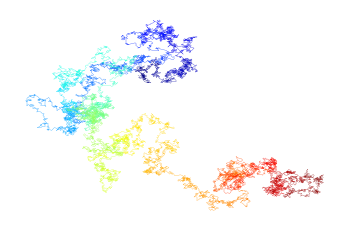

In [6]:
fig, ax = plt.subplots()
pi_coords = generate_xy_coords()

path = mpath.Path(np.column_stack([np.array(pi_coords.x), np.array(pi_coords.y)]))
verts = path.interpolated(steps=3).vertices
x,y = verts[:,0], verts[:,1]
z= np.linspace(0,1,len(x))
colorline(x,y,z,cmap=plt.get_cmap('jet'), linewidth=0.3)
plt.ylim((
    min(pi_coords.y) - max(abs(pi_coords.y)) * 0.1, 
    max(pi_coords.y) + max(abs(pi_coords.y)) * 0.1
))
plt.xlim((
    min(pi_coords.x) - max(abs(pi_coords.x)) * 0.1, 
    max(pi_coords.x) + max(abs(pi_coords.x)) * 0.1
))
ax.axis('off')
plt.show()

Here we go! A picture of a path of colorgradients generated by using Pi's digits.